In [1]:
"""
model.py
Discriminator and Generator implementation from DCGAN paper
"""

import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


test()

In [2]:
#utils.py
import torch
import torch.nn as nn


def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

Epoch [0/100] Batch 100/938                   Loss D: -117.7271, loss G: 64.4976


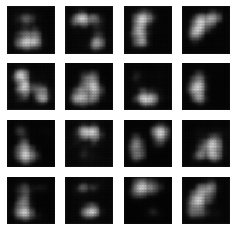

Epoch [0/100] Batch 200/938                   Loss D: -144.5102, loss G: 100.1175


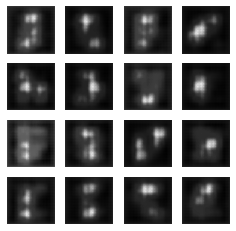

Epoch [0/100] Batch 300/938                   Loss D: -140.9219, loss G: 122.7043


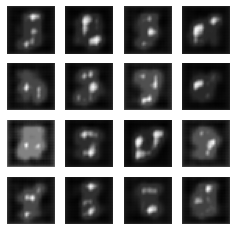

Epoch [0/100] Batch 400/938                   Loss D: -130.7016, loss G: 119.5720


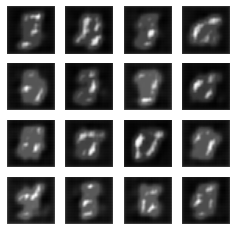

Epoch [0/100] Batch 500/938                   Loss D: -115.4106, loss G: 118.9229


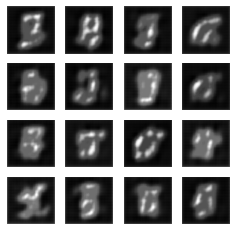

Epoch [0/100] Batch 600/938                   Loss D: -101.1147, loss G: 110.1397


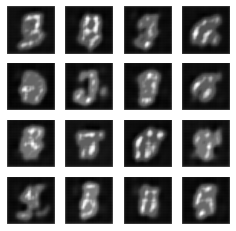

Epoch [0/100] Batch 700/938                   Loss D: -86.6048, loss G: 106.4663


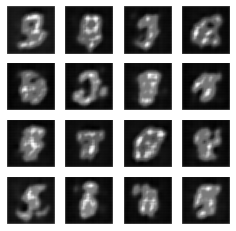

Epoch [0/100] Batch 800/938                   Loss D: -70.8417, loss G: 100.2291


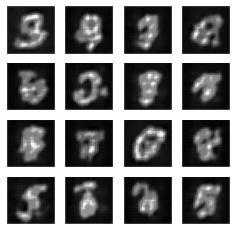

Epoch [0/100] Batch 900/938                   Loss D: -61.9039, loss G: 105.2852


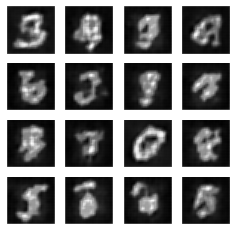

Epoch [1/100] Batch 100/938                   Loss D: -45.5989, loss G: 106.8615


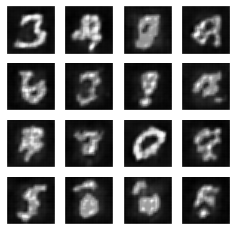

Epoch [1/100] Batch 200/938                   Loss D: -34.2382, loss G: 103.2674


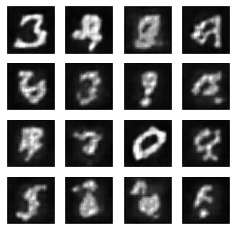

Epoch [1/100] Batch 300/938                   Loss D: -29.1425, loss G: 99.3943


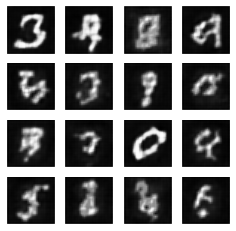

Epoch [1/100] Batch 400/938                   Loss D: -22.0249, loss G: 93.0438


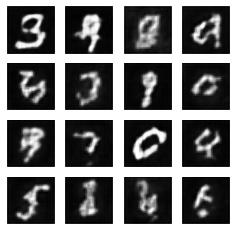

Epoch [1/100] Batch 500/938                   Loss D: -19.3413, loss G: 90.8172


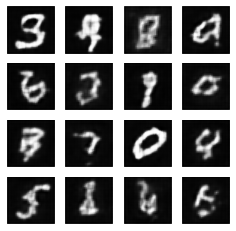

Epoch [1/100] Batch 600/938                   Loss D: -15.1352, loss G: 98.3000


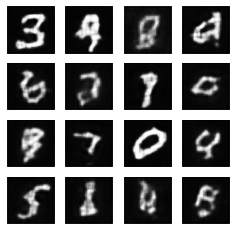

Epoch [1/100] Batch 700/938                   Loss D: -12.4720, loss G: 90.6433


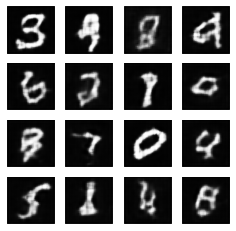

Epoch [1/100] Batch 800/938                   Loss D: -11.7481, loss G: 93.6410


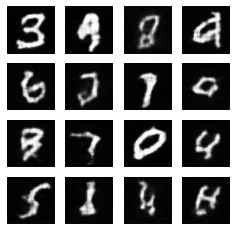

Epoch [1/100] Batch 900/938                   Loss D: -10.8028, loss G: 84.9554


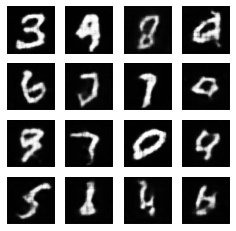

Epoch [2/100] Batch 100/938                   Loss D: -11.2113, loss G: 93.6765


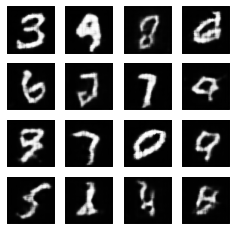

Epoch [2/100] Batch 200/938                   Loss D: -10.3234, loss G: 89.1843


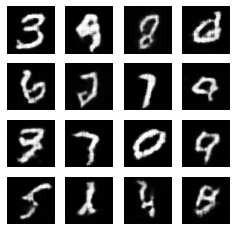

Epoch [2/100] Batch 300/938                   Loss D: -12.2652, loss G: 93.7408


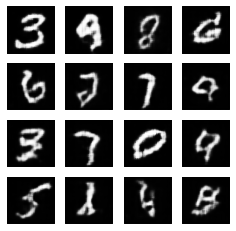

Epoch [2/100] Batch 400/938                   Loss D: -10.2813, loss G: 91.2234


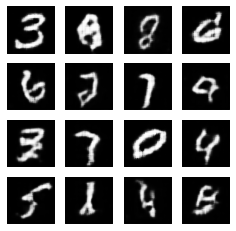

Epoch [2/100] Batch 500/938                   Loss D: -10.3486, loss G: 90.1503


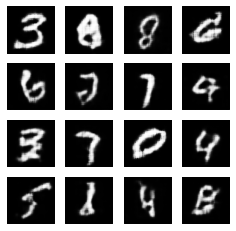

Epoch [2/100] Batch 600/938                   Loss D: -9.1325, loss G: 89.5990


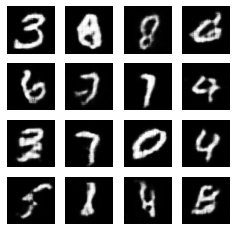

Epoch [2/100] Batch 700/938                   Loss D: -9.8271, loss G: 93.7336


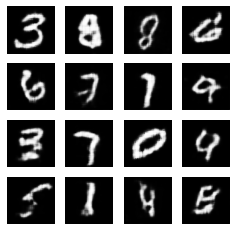

Epoch [2/100] Batch 800/938                   Loss D: -8.2167, loss G: 87.0913


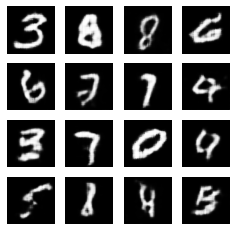

Epoch [2/100] Batch 900/938                   Loss D: -8.7733, loss G: 92.5521


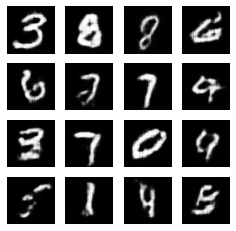

Epoch [3/100] Batch 100/938                   Loss D: -9.2147, loss G: 94.7419


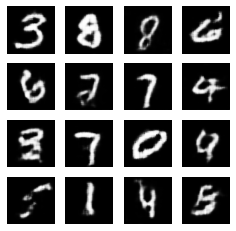

Epoch [3/100] Batch 200/938                   Loss D: -6.6289, loss G: 90.2130


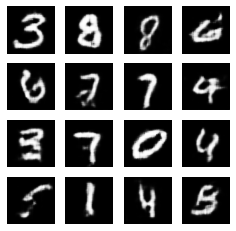

Epoch [3/100] Batch 300/938                   Loss D: -7.5851, loss G: 94.9510


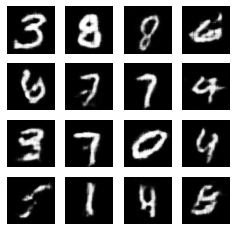

Epoch [3/100] Batch 400/938                   Loss D: -10.0421, loss G: 99.5244


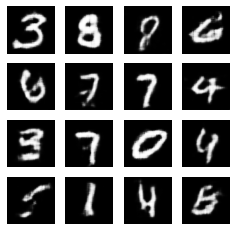

Epoch [3/100] Batch 500/938                   Loss D: -8.8024, loss G: 90.4772


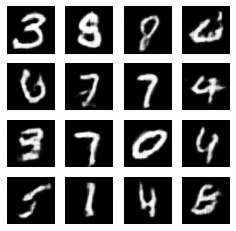

Epoch [3/100] Batch 600/938                   Loss D: -11.0437, loss G: 92.9268


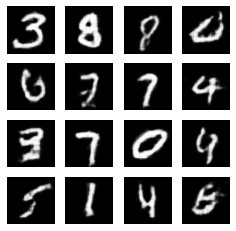

Epoch [3/100] Batch 700/938                   Loss D: -7.9415, loss G: 93.5666


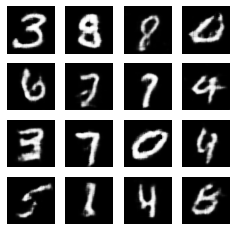

Epoch [3/100] Batch 800/938                   Loss D: -8.1797, loss G: 93.2183


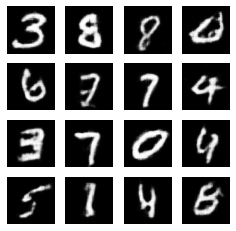

Epoch [3/100] Batch 900/938                   Loss D: -8.1335, loss G: 101.2706


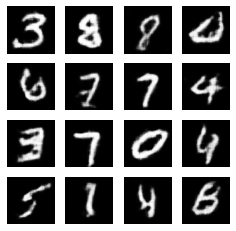

Epoch [4/100] Batch 100/938                   Loss D: -9.6221, loss G: 92.4909


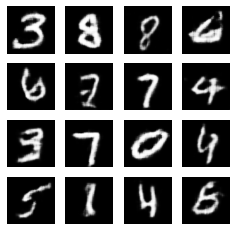

Epoch [4/100] Batch 200/938                   Loss D: -7.7188, loss G: 94.0682


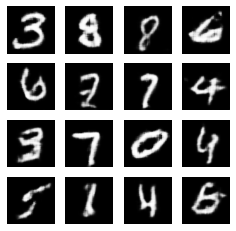

Epoch [4/100] Batch 300/938                   Loss D: -9.6629, loss G: 96.4105


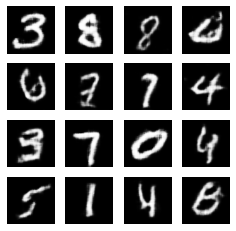

Epoch [4/100] Batch 400/938                   Loss D: -10.6208, loss G: 96.2542


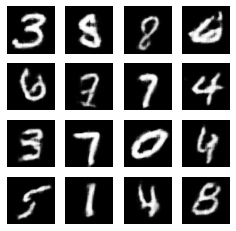

Epoch [4/100] Batch 500/938                   Loss D: -10.3892, loss G: 94.7537


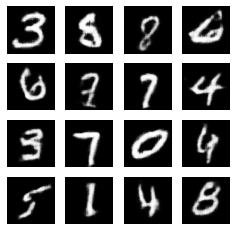

Epoch [4/100] Batch 600/938                   Loss D: -6.8905, loss G: 97.8441


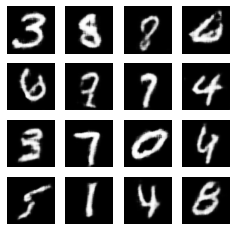

Epoch [4/100] Batch 700/938                   Loss D: -6.9202, loss G: 103.4313


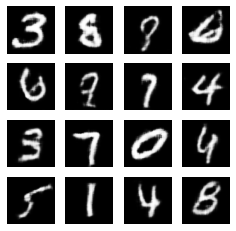

Epoch [4/100] Batch 800/938                   Loss D: -6.8885, loss G: 98.6554


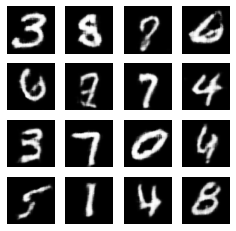

Epoch [4/100] Batch 900/938                   Loss D: -9.5503, loss G: 95.4438


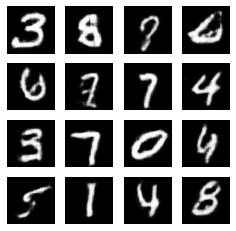

Epoch [5/100] Batch 100/938                   Loss D: -8.2640, loss G: 98.4453


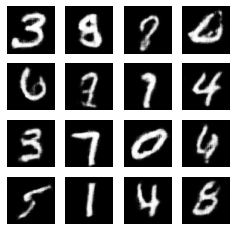

Epoch [5/100] Batch 200/938                   Loss D: -4.7579, loss G: 94.8370


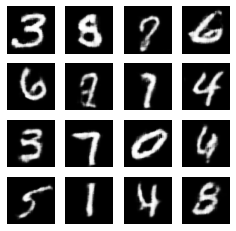

Epoch [5/100] Batch 300/938                   Loss D: -7.5654, loss G: 92.4264


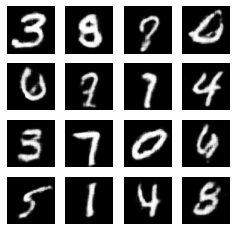

Epoch [5/100] Batch 400/938                   Loss D: -6.8901, loss G: 94.0012


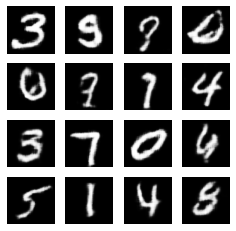

Epoch [5/100] Batch 500/938                   Loss D: -6.0334, loss G: 93.8718


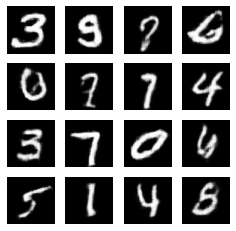

Epoch [5/100] Batch 600/938                   Loss D: -5.5184, loss G: 97.2684


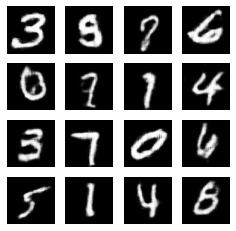

Epoch [5/100] Batch 700/938                   Loss D: -6.4004, loss G: 98.1054


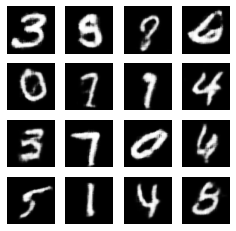

Epoch [5/100] Batch 800/938                   Loss D: -6.9521, loss G: 98.0315


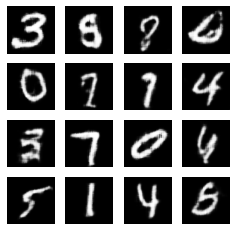

Epoch [5/100] Batch 900/938                   Loss D: -7.2042, loss G: 95.5500


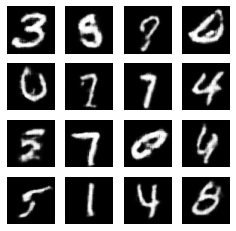

Epoch [6/100] Batch 100/938                   Loss D: -8.2163, loss G: 100.9222


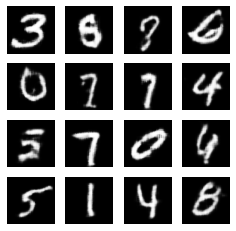

Epoch [6/100] Batch 200/938                   Loss D: -6.3027, loss G: 93.3881


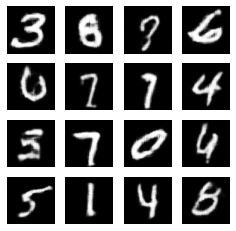

Epoch [6/100] Batch 300/938                   Loss D: -5.1744, loss G: 94.7540


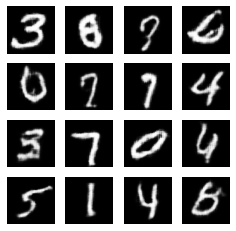

Epoch [6/100] Batch 400/938                   Loss D: -6.7750, loss G: 94.9423


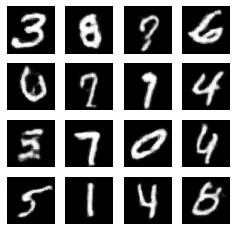

Epoch [6/100] Batch 500/938                   Loss D: -8.4610, loss G: 92.6922


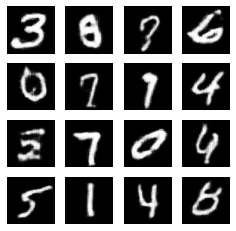

Epoch [6/100] Batch 600/938                   Loss D: -7.4445, loss G: 93.3109


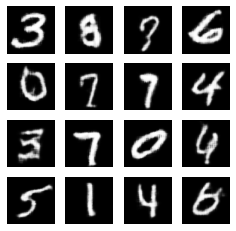

Epoch [6/100] Batch 700/938                   Loss D: -6.9435, loss G: 94.3109


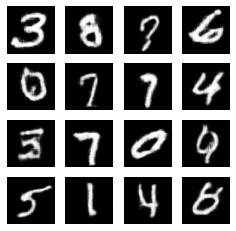

Epoch [6/100] Batch 800/938                   Loss D: -5.0696, loss G: 95.3082


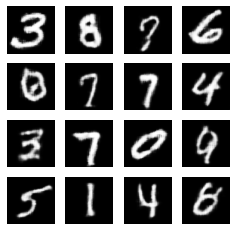

Epoch [6/100] Batch 900/938                   Loss D: -6.3375, loss G: 94.6433


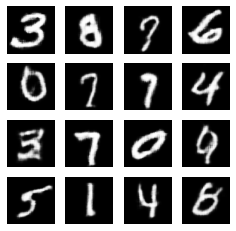

Epoch [7/100] Batch 100/938                   Loss D: -5.7762, loss G: 95.3493


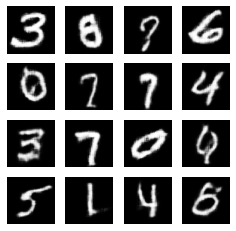

Epoch [7/100] Batch 200/938                   Loss D: -4.9871, loss G: 92.0840


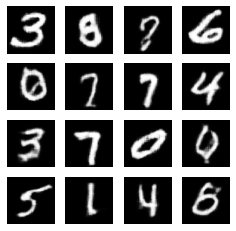

Epoch [7/100] Batch 300/938                   Loss D: -7.3949, loss G: 93.8932


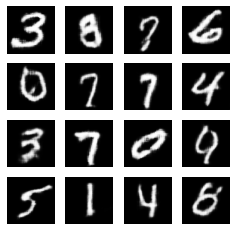

Epoch [7/100] Batch 400/938                   Loss D: -4.9378, loss G: 95.5954


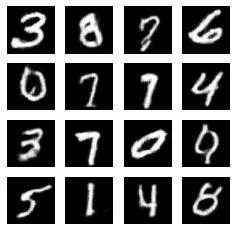

Epoch [7/100] Batch 500/938                   Loss D: -6.6182, loss G: 98.9794


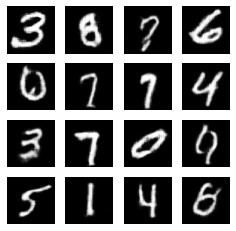

Epoch [7/100] Batch 600/938                   Loss D: -5.5990, loss G: 94.5582


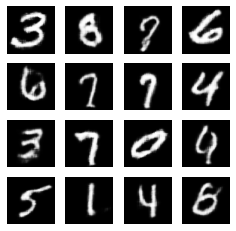

Epoch [7/100] Batch 700/938                   Loss D: -7.2641, loss G: 99.5822


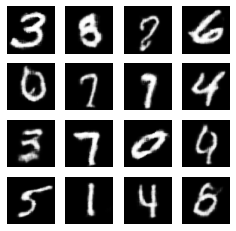

Epoch [7/100] Batch 800/938                   Loss D: -4.3009, loss G: 97.5453


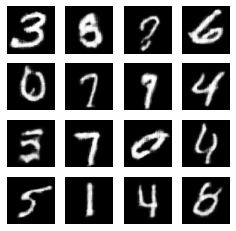

Epoch [7/100] Batch 900/938                   Loss D: -4.1499, loss G: 93.9362


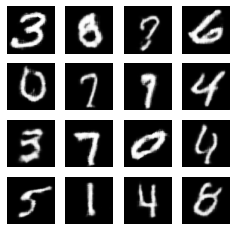

Epoch [8/100] Batch 100/938                   Loss D: -5.9366, loss G: 96.1380


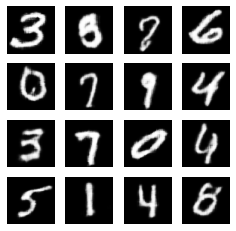

Epoch [8/100] Batch 200/938                   Loss D: -5.2221, loss G: 93.7083


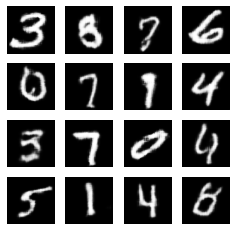

Epoch [8/100] Batch 300/938                   Loss D: -6.7337, loss G: 99.2351


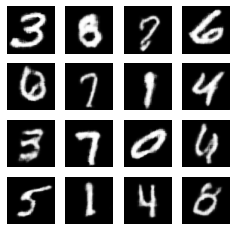

Epoch [8/100] Batch 400/938                   Loss D: -6.0631, loss G: 93.2858


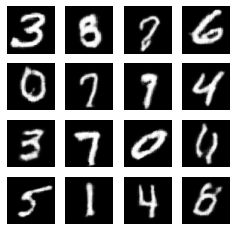

Epoch [8/100] Batch 500/938                   Loss D: -5.8156, loss G: 88.6097


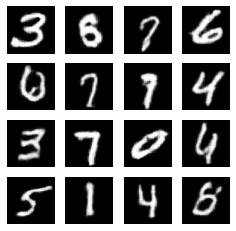

Epoch [8/100] Batch 600/938                   Loss D: -5.5362, loss G: 95.0100


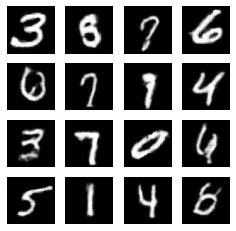

Epoch [8/100] Batch 700/938                   Loss D: -4.9527, loss G: 95.4797


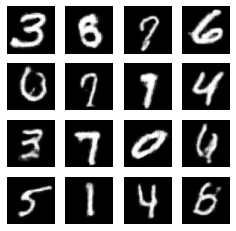

Epoch [8/100] Batch 800/938                   Loss D: -5.7284, loss G: 91.9050


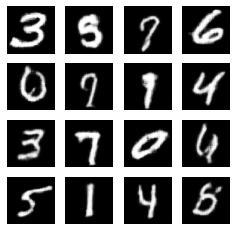

Epoch [8/100] Batch 900/938                   Loss D: -5.1908, loss G: 100.1517


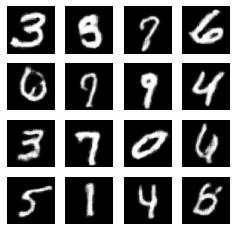

Epoch [9/100] Batch 100/938                   Loss D: -5.1272, loss G: 97.3813


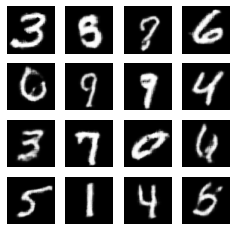

Epoch [9/100] Batch 200/938                   Loss D: -5.7989, loss G: 90.1721


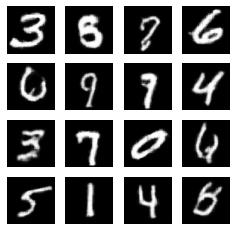

Epoch [9/100] Batch 300/938                   Loss D: -5.4588, loss G: 96.9296


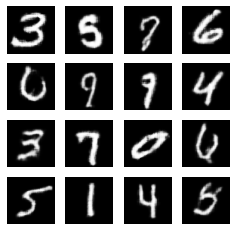

Epoch [9/100] Batch 400/938                   Loss D: -5.7908, loss G: 95.4788


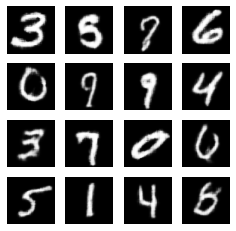

Epoch [9/100] Batch 500/938                   Loss D: -6.9689, loss G: 95.2551


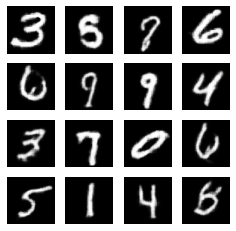

Epoch [9/100] Batch 600/938                   Loss D: -4.4474, loss G: 88.4421


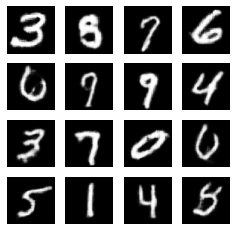

Epoch [9/100] Batch 700/938                   Loss D: -5.1237, loss G: 94.8081


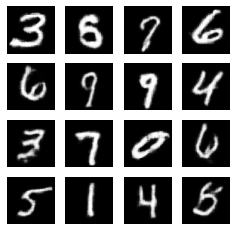

Epoch [9/100] Batch 800/938                   Loss D: -3.6046, loss G: 93.4006


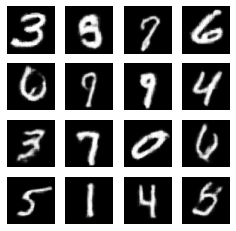

Epoch [9/100] Batch 900/938                   Loss D: -4.7876, loss G: 94.0274


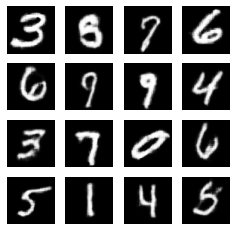

Epoch [10/100] Batch 100/938                   Loss D: -3.0562, loss G: 95.8953


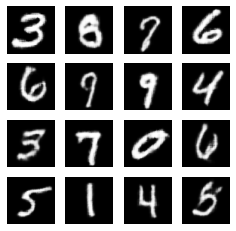

Epoch [10/100] Batch 200/938                   Loss D: -6.3377, loss G: 94.6474


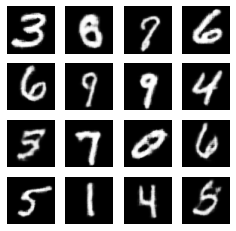

Epoch [10/100] Batch 300/938                   Loss D: -4.6148, loss G: 92.1276


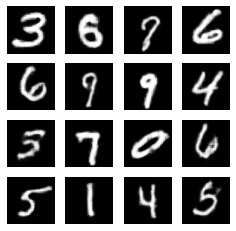

Epoch [10/100] Batch 400/938                   Loss D: -5.1741, loss G: 93.3561


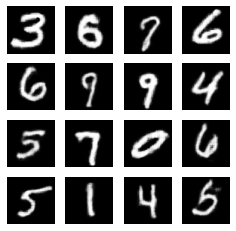

Epoch [10/100] Batch 500/938                   Loss D: -3.4816, loss G: 91.2598


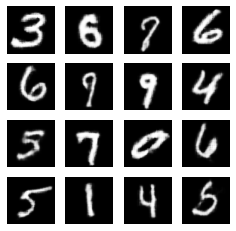

Epoch [10/100] Batch 600/938                   Loss D: -5.9966, loss G: 101.8483


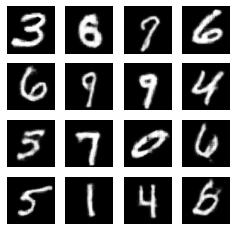

Epoch [10/100] Batch 700/938                   Loss D: -5.6316, loss G: 92.3239


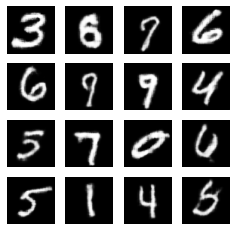

Epoch [10/100] Batch 800/938                   Loss D: -4.3089, loss G: 100.2220


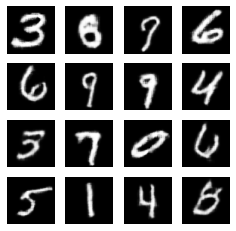

Epoch [10/100] Batch 900/938                   Loss D: -5.0074, loss G: 100.8208


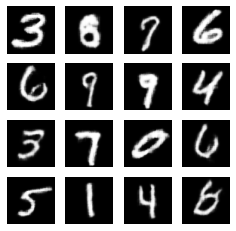

In [ ]:
#train.py

"""
Training of WGAN-GP
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# from utils import gradient_penalty, save_checkpoint, load_checkpoint
# from model import Discriminator, Generator, initialize_weights

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                fake_16 = fake.view(-1, 64, 64)[:16]
                import matplotlib.pyplot as plt
                fig = plt.figure(figsize=(4,4))
                for i in range(16):
                    plt.subplot(4,4,i+1)
                    plt.imshow(fake_16[i].to('cpu'), cmap='gray')
                    plt.axis('off')
                plt.show()

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1